In [28]:
import nltk
import pandas as pd
import numpy as np
import re
regex = re.compile('[^A-Za-zÀ-ÿ]')
import seaborn as sns
import numpy as np
import itertools
from tqdm import tqdm
from functools import reduce
import matplotlib.pyplot as plt
from collections import Counter

import itertools
import collections

import pickle

import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from proj2_helpers import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn import linear_model

### DATA LOADING

In [29]:
DIM_EMB=20

In [30]:
COOC_PATH = './cooc.pkl'
VOC_PATH = './vocab.pkl'
CUT_VOC_PATH = './vocab_cut.txt'
EMBEDDINGS_PATH = './embeddings.npy'
DATA_TRAIN_POS_PATH = './Datasets/twitter-datasets/pos_train.txt' 
DATA_TRAIN_NEG_PATH = './Datasets/twitter-datasets/neg_train.txt' 

In [31]:
RESULT_POS_PATH = './Results/resPtrain_nd.txt'
RESULT_NEG_PATH = './Results/resNtrain_nd.txt'

In [32]:
with open(COOC_PATH, 'rb') as f:
    cooc_matrix = pickle.load(f)
    
with open(VOC_PATH, 'rb') as f:
    vocabulary = pickle.load(f)
    
embeddings = np.load(EMBEDDINGS_PATH)

# load the data files = list with each line being a tweet
pos_data =open(DATA_TRAIN_POS_PATH, "r").read().splitlines()
neg_data =open(DATA_TRAIN_NEG_PATH, "r").read().splitlines()
cut_vocabulary =open(CUT_VOC_PATH, "r").read().splitlines()
result_pos =open(RESULT_POS_PATH, "r").read().splitlines()
result_neg =open(RESULT_NEG_PATH, "r").read().splitlines()

In [33]:
embeddings.shape

(13191, 20)

In [34]:
pos = [x.strip() for x in result_pos[0].split(',')]
neg = [x.strip() for x in result_neg[0].split(',')]

### EXTRACTING MEAN WORD VECTOR ON TRAIN SETS 

In [35]:
# get vocab equivalence to tweet woirds

idx_pos_tweets = [[vocabulary.get((regex.sub(' ', ' '.join(regex.sub(' ', t).split()))), -1) for t in line.strip().split()] for line in pos]
idx_pos_tweets = [[t for t in tokens if t>=0] for tokens in idx_pos_tweets]

idx_neg_tweets = [[vocabulary.get((regex.sub(' ', ' '.join(regex.sub(' ', t).split()))), -1) for t in line.strip().split()] for line in pos]
idx_neg_tweets = [[t for t in tokens if t>=0] for tokens in idx_neg_tweets]

# get dense vector equivalence to tweet words
pos_tweets_word_vector = [[embeddings[wd2voc][:] for wd2voc in tweet_words] for tweet_words in idx_pos_tweets]

neg_tweets_word_vector = [[embeddings[wd2voc][:] for wd2voc in tweet_words] for tweet_words in idx_neg_tweets]

# get mean word vector of each tweet
pos_tweets_mean_vector = [np.mean(wordvectors,axis=0) for wordvectors in pos_tweets_word_vector]

neg_tweets_mean_vector = [np.mean(wordvectors,axis=0) for wordvectors in neg_tweets_word_vector]

/Users/sirinesayagh/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sirinesayagh/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
label_pos = [1] * len(pos)
pos_df = pd.DataFrame(list(zip(label_pos, pos, idx_pos_tweets,pos_tweets_word_vector,pos_tweets_mean_vector)),\
                      columns=["Sentiment","Tweet","Token_idx","Words_Vectors","Mean_Word_Vector"]) #create a df
del label_pos
pos_df.head()

,Sentiment,Tweet,Token_idx,Words_Vectors,Mean_Word_Vector
0,1,['dunno justin read mention justin god know ho...,"[1312, 439, 206, 459, 439, 140, 4, 45, 9, 209]","[[-0.14710372696628293, 1.086682084363625, -0....","[-0.35072209557061357, 0.7329244231493826, -0...."
1,1,'logic dumb even crop name photo tsk',"[2094, 1194, 68, 4664, 173, 309, 4455]","[[-1.556495316687639, 1.9481823643797989, -0.8...","[-0.39852621887554446, 0.2221294616363131, 0.0..."
2,1,'put casper box look battle bitch',"[156, 7907, 308, 25, 1357, 196]","[[-0.6393250135775723, -0.24818839004606633, -...","[0.03351917175659059, 0.09320186637661715, 0.0..."
3,1,'thanks sir trip lil mama keep doin',"[26, 1109, 525, 420, 856, 98, 1453]","[[-0.5080396613782544, 0.37463485113504796, -0...","[-0.2263552822782026, 0.5498975401627835, 0.19..."
4,1,'visit brother best birthday gift every',"[487, 271, 43, 91, 725, 172]","[[-0.47369600816379476, -0.30626771725887386, ...","[-0.2748481111946549, 0.14258626686447956, 0.0..."


In [37]:
label_neg = [-1] * len(neg)
neg_df = pd.DataFrame(list(zip(label_neg,neg, idx_neg_tweets,neg_tweets_word_vector,neg_tweets_mean_vector)),\
                      columns=["Sentiment","Tweet","Token_idx","Words_Vectors","Mean_Word_Vector"]) #create a df
del label_neg
neg_df.head(1000)

,Sentiment,Tweet,Token_idx,Words_Vectors,Mean_Word_Vector
0,-1,['vince tresorpack difficulty object disassemb...,"[1312, 439, 206, 459, 439, 140, 4, 45, 9, 209]","[[-0.14710372696628293, 1.086682084363625, -0....","[-0.35072209557061357, 0.7329244231493826, -0...."
1,-1,'glad dot take tomorrow thankful start',"[2094, 1194, 68, 4664, 173, 309, 4455]","[[-1.556495316687639, 1.9481823643797989, -0.8...","[-0.39852621887554446, 0.2221294616363131, 0.0..."
2,-1,'celtic regular season fuck play playoff',"[156, 7907, 308, 25, 1357, 196]","[[-0.6393250135775723, -0.24818839004606633, -...","[0.03351917175659059, 0.09320186637661715, 0.0..."
3,-1,'could actually kill girl sorry',"[26, 1109, 525, 420, 856, 98, 1453]","[[-0.5080396613782544, 0.37463485113504796, -0...","[-0.2263552822782026, 0.5498975401627835, 0.19..."
4,-1,'find hard believe afraid',"[487, 271, 43, 91, 725, 172]","[[-0.47369600816379476, -0.30626771725887386, ...","[-0.2748481111946549, 0.14258626686447956, 0.0..."
...,...,...,...,...,...
995,-1,'hope expensive',"[10, 1082, 540, 229, 9]","[[-0.4501262187043856, 0.39455591364676856, -0...","[-0.5294881894522154, 0.3331186413435129, 0.31..."
996,-1,'veto lift bring mcdonalds',"[193, 1995, 1785, 2010, 179, 3018, 331]","[[0.4379044107300885, 1.5083934849720537, -0.7...","[-0.0889891269310521, 0.4063476666019291, 0.08..."
997,-1,'want grow big fat like badly',"[605, 93, 216, 6, 896, 3268, 50]","[[-0.3091583487072667, 1.167363582424688, -0.4...","[-0.44712345374967594, 0.6397136345706483, -0...."
998,-1,'wake soo sad',[33],"[[-0.5223331548199615, 0.5166696367743184, -0....","[-0.5223331548199615, 0.5166696367743184, -0.4..."


---
Ligne suivante regroupe pos et neg

In [38]:
full_df = pd.concat([pos_df,neg_df],ignore_index=True) #regroup the dfs, ignore index in order to get new ones (->no duplicate)

full_df = full_df.sample(frac=1) #shuffles the rows

In [39]:
full_df["Mean_Word_Vector"].isna().sum()

208

In [40]:
full_df.shape

(171972, 5)

In [41]:
full_df

,Sentiment,Tweet,Token_idx,Words_Vectors,Mean_Word_Vector
145344,-1,'tomorrow saturday gon long day',"[7, 183, 46, 4]","[[-0.5275402626308756, 0.43521171009270515, -0...","[-0.579490813174951, 0.538270137619321, -0.363..."
170045,-1,'wish toronto instead stay home',"[3, 257, 7363, 4936, 1024, 1853, 36, 4437, 4520]","[[-0.5321139775736375, 0.4248646353933472, -0....","[0.11160367767240977, 0.20963510747689065, -0...."
41330,1,'well roll blunt tonight star war high fuck',"[22, 566, 2486, 81, 413, 640, 158, 85]","[[-0.5890456639014277, 0.41502861026588084, -0...","[-0.11260263109467722, 0.4431678518080961, -0...."
166332,-1,'nobody want talk',"[1175, 2880, 5839, 144, 6]","[[0.060195119170116204, -1.3505118862957377, -...","[-0.1243688849000872, -0.3976252985399829, -0...."
139379,-1,'could san antonio right',"[191, 93, 552, 139, 531]","[[-0.5449155906513259, 0.26743106757007246, 0....","[0.03434875148169421, 0.5011731207939023, 0.12..."
...,...,...,...,...,...
87239,-1,'happen bud',"[0, 739, 923, 849, 25, 808, 4849, 156, 103]","[[-0.4641674500250573, 0.42570638782998044, -0...","[0.15239660769707608, 0.303018922377324, -0.20..."
52615,1,'smile could bite happiness someone see day',"[164, 41, 1039, 1671, 105, 11, 5]","[[-0.14122965108571198, 0.14153544291052939, -...","[-0.08058966986469114, 0.26101192473582013, -0..."
163912,-1,'tales dead west audio mix furious rockabilly ...,"[22, 302, 245, 2525, 193]","[[-0.5890456639014277, 0.41502861026588084, -0...","[-0.1158356480280864, 0.24377852592211555, -0...."
131482,-1,'someone give anvil semi cure headache need',"[0, 524, 2592, 29, 29]","[[-0.4641674500250573, 0.42570638782998044, -0...","[-0.5398452869744733, 0.3528987992762237, -0.4..."


In [42]:
X = full_df['Mean_Word_Vector'].to_numpy()

In [43]:
X.shape

(171972,)

In [44]:
X = [x if not np.isnan(x).any() else np.zeros((20,)) for x in X]
len(X)

171972

In [45]:
X = np.concatenate(X, axis=0).reshape((full_df.shape[0],DIM_EMB))

In [46]:
X.shape

(171972, 20)

In [47]:
y = full_df['Sentiment'].to_numpy()
y.shape

(171972,)

### MINMAXSCALER AND PCA ON TRAIN SETS

In [48]:
scaler = MinMaxScaler(feature_range=[0, 1])

In [49]:
X_rescaled = scaler.fit_transform(X)

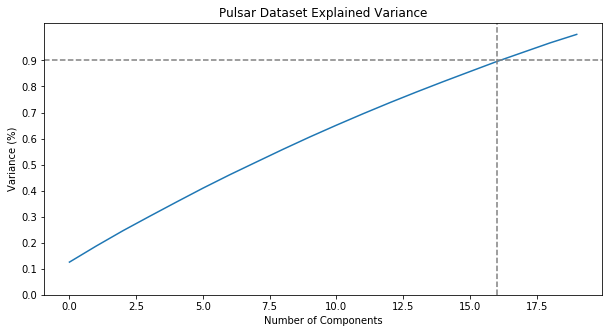

In [50]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
fig = plt.figure(figsize=(10,5))
x=np.cumsum(pca.explained_variance_ratio_)
plt.plot(x)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.yticks(np.arange(0, 1, 0.1))
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=16,color='gray',linestyle='--')
plt.show()

We see that we have selecting 16 components we can preserve something around 90% of the total variance of the data.

In [75]:
pca = PCA(n_components=16)
dataset = pca.fit_transform(X_rescaled)

### TRYING SVM FITTING: SEEING ACCURACY BY SPLITTING THE DATASET IN A TEST AND A TRAIN SET

In [76]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y, random_state=0)

In [77]:
clf = linear_model.LogisticRegression(C=1e5,\
max_iter=10000,n_jobs=-1).fit(X_train, y_train)
y_pred = clf.predict(X_test)

/Users/sirinesayagh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sirinesayagh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [78]:
cm = confusion_matrix(y_test, y_pred)
accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])

In [79]:
accuracy

0.49315004768218085

### EXTRACTING MEAN WORD VECTOR ON TEST SETS

In [80]:
RES_PATH = './result_test.txt'
test_set =open(RES_PATH, "r").read().splitlines()

In [81]:
test_set

['sea doo pro sea scooter sport portable sea doo seascootersave air stay long water',
 'shuck well work week come cheer put battery calculator',
 'stay away bug that baby',
 'madam lol perfectly fine contagious anymore mao',
 'whenever fall asleep watch always wake headache',
 'need get rid thing scare lol need car either need driver',
 'whatever terrible mood',
 'yes thanks jordan love gon call later',
 'friend text check last night',
 'follow back please unity tour come europe sweden',
 'watch dumb ass get lock today happy',
 'obsess phase kill best album ever love yew royce',
 'robert niro gay name like lewy would understand hahahahha sherlock',
 'canada grade since grade suck',
 'please say denmark would amazing live',
 'finally home',
 'custom picture frame poster frame wide complete gold frame fgd frame manufacture',
 'new follower mention followback boo',
 'yep look like best team stay proper form see bit',
 'nhs batsman suspension criticism gamesmanship associate press new york

In [82]:
# get vocab equivalence to tweet woirds

idx_test_tweets = [[vocabulary.get((regex.sub(' ', ' '.join(regex.sub(' ', t).split()))), -1) for t in line.strip().split()] for line in test_set]
idx_test_tweets = [[t for t in tokens if t>=0] for tokens in idx_test_tweets]

# get dense vector equivalence to tweet words
test_tweets_word_vector = [[embeddings[wd2voc][:] for wd2voc in tweet_words] for tweet_words in idx_test_tweets]

# get mean word vector of each tweet
test_tweets_mean_vector = [np.mean(wordvectors,axis=0) for wordvectors in test_tweets_word_vector]


/Users/sirinesayagh/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sirinesayagh/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [83]:
test_ids = np.linspace(1,10000,10000, dtype=int)
test_df = pd.DataFrame(list(zip(test_ids, test_set, idx_test_tweets,test_tweets_word_vector,test_tweets_mean_vector)),\
                      columns=["Tweet_submission_id","Tweet","Token_idx","Words_Vectors","Mean_Word_Vector"]) #create a df
del test_ids
test_df.head()

,Tweet_submission_id,Tweet,Token_idx,Words_Vectors,Mean_Word_Vector
0,1,sea doo pro sea scooter sport portable sea doo...,"[1079, 2077, 488, 1079, 4060, 436, 1951, 1079,...","[[0.7545771418230769, 0.5417753466067821, -0.3...","[0.17359848973525313, 0.6739966900020333, -0.4..."
1,2,shuck well work week come cheer put battery ca...,"[7242, 22, 27, 77, 16, 460, 156, 378, 6804]","[[-1.2264067940250245, 0.15497394762378422, 0....","[-0.4337431112273248, 0.2020129000933508, -0.2..."
2,3,stay away bug that baby,"[162, 171, 1375, 166, 76]","[[-0.3056082730359473, 0.3002315203895117, -0....","[-0.3436857359354798, 0.19822519439318748, -0...."
3,4,madam lol perfectly fine contagious anymore mao,"[2300, 7, 2873, 301, 6481, 240, 131]","[[0.9504541835268531, 0.21418896359570821, -0....","[0.5329097936052202, -0.18495738575262563, 0.1..."
4,5,whenever fall asleep watch always wake headache,"[1113, 330, 603, 42, 63, 223, 817]","[[-0.9415122235016096, -0.9807237355649092, -1...","[-0.04126264263608654, 0.15105353028164056, -0..."


In [84]:
test_df.shape

(10000, 5)

In [87]:
X_test = test_df['Mean_Word_Vector'].to_numpy()
X_test = [x if not np.isnan(x).any() else np.zeros((20,)) for x in X_test]
X_test = np.concatenate(X_test, axis=0).reshape((test_df.shape[0],DIM_EMB))

In [88]:
len(X_test)

10000

### MINMAXSCALER AND PCA ON TEST SETS

In [89]:
test_rescaled = scaler.fit_transform(X_test)

In [90]:
pca = PCA(n_components=16)
test= pca.fit_transform(test_rescaled)

In [91]:
# TRAIN LR ON WHOLE TRAINING SET
clf = linear_model.LogisticRegression(C=1e5,\
max_iter=10000,n_jobs=-1).fit(dataset, y)
y_pred = clf.predict(test)

/Users/sirinesayagh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sirinesayagh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [92]:
len(y_pred)

10000

### CREATE A SUBMISSION

In [93]:
test_id = test_df['Tweet_submission_id'].to_numpy()

In [94]:
len(test_id)

10000

In [95]:
create_csv_submission(test_id,y_pred,"LR_SUB.csv")